This notebook looks at the dF_F signal for rewarded and unrewarded trials for each of the neuromodulators (DA, NE, 5HT, ACh) recorded in the Nucleus Acumbens during a foraging task.

In [1]:

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils


from matplotlib.collections import LineCollection
import pandas as pd

## Load and format the Neuromodulator (NM) data and behavioural labels

In [2]:
# load the dataframe
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [3]:
1765*4

7060

In [4]:
# load the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [5]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [6]:
traces.keys()

dict_keys(['DA NAc', 'NE NAc', '5HT NAc', 'ACh NAc'])

In [7]:
# Combine the traces for all NMs into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape


(218572, 4)

In [8]:
# the individual nms
individual_datasets = utils.individual_datasets(traces_=traces)

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [9]:
n_trials = 1765

In [10]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [12]:
# get the nm data for the rewarded/unrewarded trials

all_nms_HD, trial_labels_, choice_labels, n_licks, rpe_labels = utils.format_data(all_nms, df=df_trials_ses, trace_times_=trace_times, choice_times_=choice_times)


neural tensor shape:  torch.Size([1717, 80])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [13]:
np.std(all_nms_HD.numpy(), axis=0).shape

(80,)

In [14]:
# get the average df_f signal for all the 1717 trials
ave_nms = np.average(all_nms_HD, axis=0)

## Make the plots

In [29]:
def nm_signals(nm_data, labels=['DA', 'NE', '5HT', 'ACh']):

    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(2,2, figure=fig)

    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[1,1])


    for i, nm in enumerate(nm_data):

        nm_HD, trial_labels, choice_labels, n_licks, rpe_labels = utils.format_data(nm_data[i], df_trials_ses, trace_times, choice_times)
        
        #all trials average
        ave_nm = np.average(nm_HD, axis=0)

        # rewarded trials average
        rewarded_ave = np.average(nm_HD[trial_labels==1],axis=0)

        # unrewarded trials average
        unrewarded_ave = np.average(nm_HD[trial_labels==0],axis=0)
        
        # plot all trials
        ax1.plot(ave_nm, label=labels[i])

        # plot rewarded trials
        ax2.plot(rewarded_ave, label=labels[i])

        # plot unrewarded trials
        ax3.plot(unrewarded_ave, label=labels[i])


    ax1.set_xlabel('timesteps(seconds)')
    ax1.set_ylabel('df_f signal')
    ax1.set_title('All trials')
    ax1.legend()

    ax2.set_xlabel('timesteps(seconds)')
    ax2.set_ylabel('df_f signal')
    ax2.set_title('Rewarded Trials')
    ax2.legend()

    ax3.set_xlabel('timesteps(seconds)')
    ax3.set_ylabel('df_f signal')
    ax3.set_title('Unrewarded Trials')
    ax3.legend()


    gs.tight_layout(figure=fig)

    plt.tight_layout()


In [30]:
type(individual_datasets)

list

neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)
neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)
neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)
neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)


/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_13401/1293409812.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


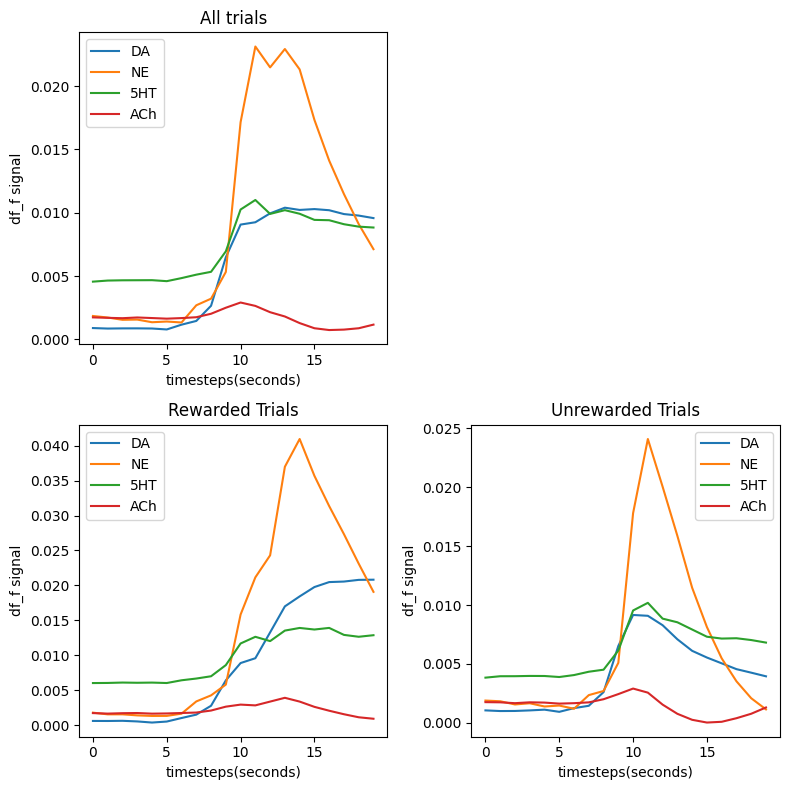

In [ ]:
nm_signals(individual_datasets)

Now let's group them by Neuromodulators.

In [31]:
# Separate function into one that produces the average traces and one that plots them
def ave_nm_signal(nm_data):

    # lists to store the average values
    all_ave = []
    all_rewarded = []
    all_unrewarded = []

    # lists to store the errors (st. d)
    alt_sd = []
    rewarded_sd = []
    unrewarded_sd = []

    for nm in nm_data:

        # get the nm data in the 1s window around the choice
        nm_HD, trial_labels, choice_labels, n_licks, rpe_labels = utils.format_data(nm, df_trials_ses, trace_times, choice_times)
        
        # all trials average and sd
        ave_nm = np.average(nm_HD, axis=0)
        all_sd = np.std(nm_HD.numpy(), axis=0)

        all_ave.append(ave_nm)
        alt_sd.append(all_sd)

        # rewarded trials average and sd
        rewarded_ave = np.average(nm_HD[trial_labels==1],axis=0)
        r_sd = np.std(nm_HD[trial_labels==1].numpy(), axis=0)

        all_rewarded.append(rewarded_ave)
        rewarded_sd.append(r_sd)

        # unrewarded trials average and sd
        unrewarded_ave = np.average(nm_HD[trial_labels==0],axis=0)
        unr_sd = np.std(nm_HD[trial_labels==0].numpy(), axis=0)

        all_unrewarded.append(unrewarded_ave)
        unrewarded_sd.append(unr_sd)

    sd_lists = [alt_sd, rewarded_sd, unrewarded_sd]

    return all_ave, all_rewarded, all_unrewarded, sd_lists


In [32]:
ave_nm_, rewarded_ave_, unrewarded_ave_, sd_lists = ave_nm_signal(individual_datasets) 

neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [33]:
len(sd_lists)

3

In [34]:
sd_lists[2][3]

array([0.00395368, 0.00401367, 0.00405143, 0.00405768, 0.00398732,
       0.00398647, 0.00393415, 0.00400911, 0.00399988, 0.00404183,
       0.0041532 , 0.00402012, 0.00391139, 0.00388171, 0.00378369,
       0.0036522 , 0.0037269 , 0.00379448, 0.00374706, 0.00374168])

In [35]:
def plot_ave_signal(all_signals, rewarded_signals, unrewarded_signals, sd_lists_, labels=['Dopamine','Norepinephrine','Serotonin','Acetylcholine']):

    fig = plt.figure(figsize=(8,6))
    gs = gridspec.GridSpec(2,2, figure=fig)

    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,0])
    ax4 = fig.add_subplot(gs[1,1])

    axes = [ax1, ax2, ax3, ax4]
    time_points = np.round(np.arange(-0.5,0.50,0.05),2)

    # loop thru each nm
    for i,ax  in enumerate(axes) :

        # s.d.s 
        yerr_r = sd_lists_[1][i]
        yerr_ur = sd_lists_[2][i]

        # plot all trials signal
        ax.errorbar(time_points, rewarded_signals[i],color='g')
        ax.fill_between(time_points,rewarded_signals[i]+yerr_r,rewarded_signals[i]-yerr_r,label='rewarded trials',color='g',alpha=0.25)
        ax.errorbar(time_points, unrewarded_signals[i],color='r')
        ax.fill_between(time_points,unrewarded_signals[i]+yerr_ur,unrewarded_signals[i]-yerr_ur,label='unrewarded trials',color='r',alpha=0.25)
        ax.set_ylim(0,0.07)
        ax.axvline(x=0,label='choice time',linestyle='--', c='k')
        ax.set_xlabel('Time from choice (s)', fontsize=13)
        ax.set_ylabel('dF_F signal', fontsize=13)
        ax.set_title('{}'.format(labels[i]), fontsize=13)
        ax.legend(loc=2, fontsize='small')

    
    plt.suptitle("4 Neuromodulators Recorded Simultaneously Using Fiber Photometry", fontsize=15)
    plt.tight_layout()
    gs.tight_layout(figure=fig)


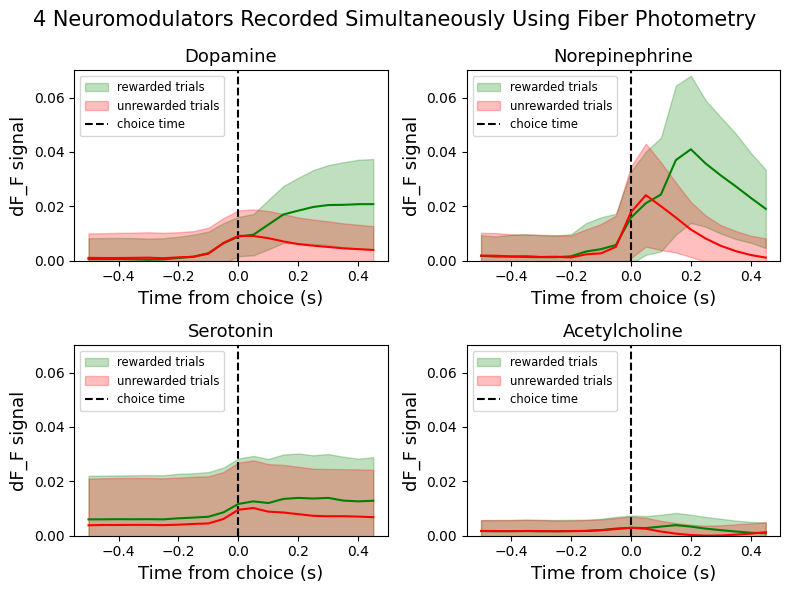

In [36]:
plot_ave_signal(ave_nm_, rewarded_ave_, unrewarded_ave_,sd_lists)
    